In [1]:
import numpy as np
import cv2
import mat73
import numpy as np
import cv2
import os
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.widgets import RectangleSelector

In [2]:
dataset_dir = 'data/'
mat_files = sorted([file for file in os.listdir(dataset_dir) if file.endswith('.mat')])
mat_files

# Specify inspection sequence
idx = 4
mat_data = scipy.io.loadmat(os.path.join(dataset_dir, mat_files[idx]))
image_sequence = np.float32(mat_data["imageArray"])
h, w, sequence_size = image_sequence.shape[0], image_sequence.shape[1], image_sequence.shape[2]

In [3]:
from scipy.signal import medfilt

def apply_median(pixel_signal):
    return medfilt(pixel_signal, kernel_size=3)

h, w, sequence_size = image_sequence.shape
imageMatrix = image_sequence.reshape(h * w, sequence_size)
imageMatrix = imageMatrix[:, 12:]

imageMatrix = np.apply_along_axis(apply_median, axis=1, arr=imageMatrix)

imageMatrix = imageMatrix - np.mean(imageMatrix, axis=1, keepdims=True)

n_components = 64
latent_dim = n_components

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)  
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)  
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
train_data = torch.tensor(imageMatrix, dtype=torch.float32, device=device)
dataset = TensorDataset(train_data)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

model = Autoencoder(input_dim=train_data.shape[1], latent_dim=latent_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [6]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for batch in dataloader:
        x = batch[0]
        optimizer.zero_grad()
        x_recon, _ = model(x)
        loss = criterion(x_recon, x)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

Epoch 0: Loss = 50.34438705444336
Epoch 10: Loss = 10.75894832611084
Epoch 20: Loss = 9.438934326171875
Epoch 30: Loss = 9.2515287399292
Epoch 40: Loss = 9.786284446716309
Epoch 50: Loss = 8.97616958618164
Epoch 60: Loss = 9.07510757446289
Epoch 70: Loss = 9.001015663146973
Epoch 80: Loss = 9.154863357543945
Epoch 90: Loss = 9.19074535369873


In [7]:
model.eval()
with torch.no_grad():
    _, principal_comp = model(train_data)

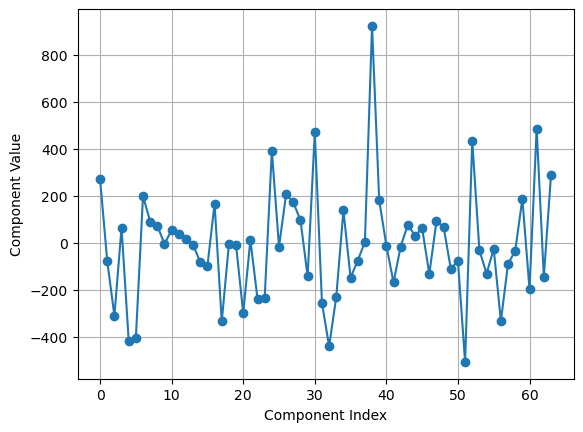

In [8]:
plt.plot(principal_comp[70000, :].cpu().numpy(), marker='o')
plt.xlabel("Component Index")
plt.ylabel("Component Value")
plt.grid(True)
plt.show()

In [9]:
pca_array = principal_comp.cpu().numpy().reshape(h, w, n_components)

pca_images = np.array([((pca_array[:, :, i] - np.min(pca_array[:, :, i])) /
                        (np.max(pca_array[:, :, i]) - np.min(pca_array[:, :, i]) + 1e-8))
                        for i in range(n_components)])

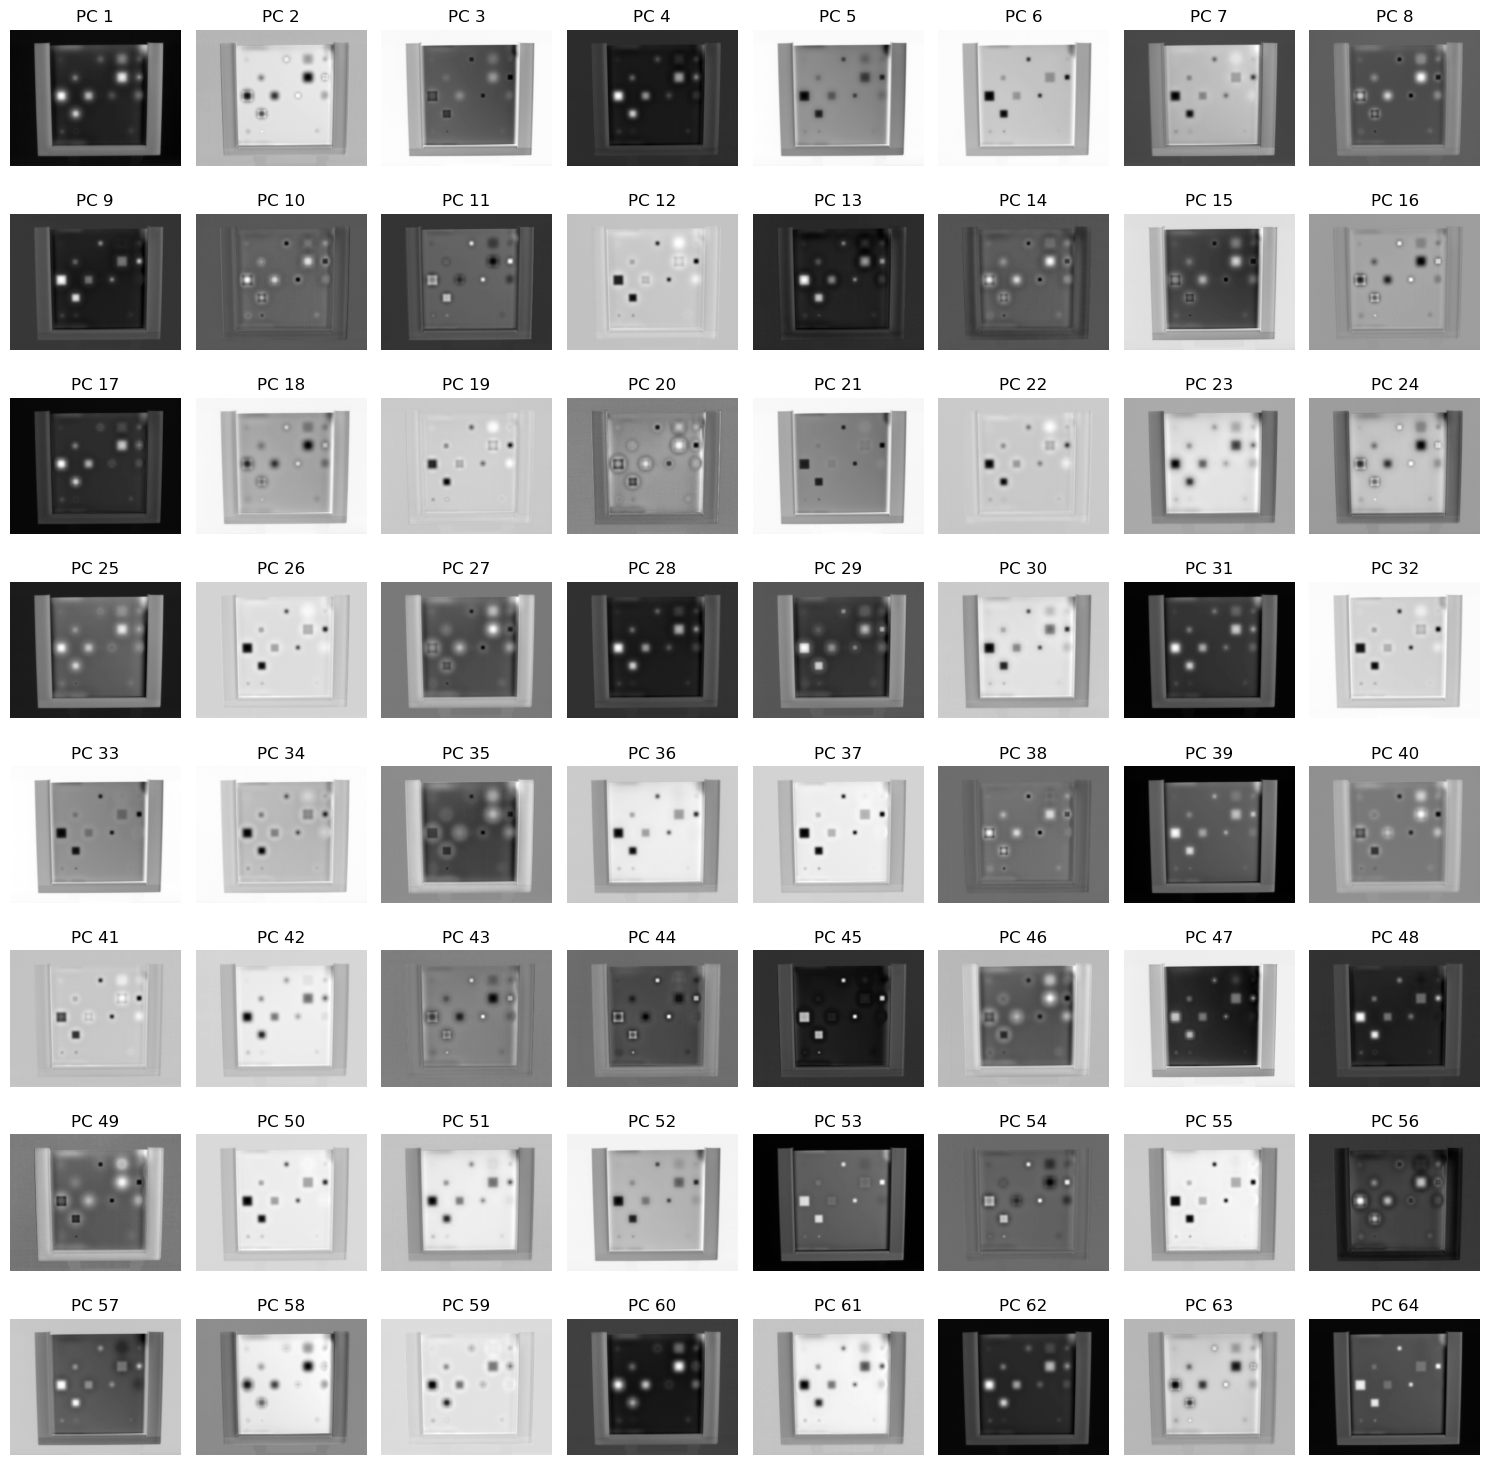

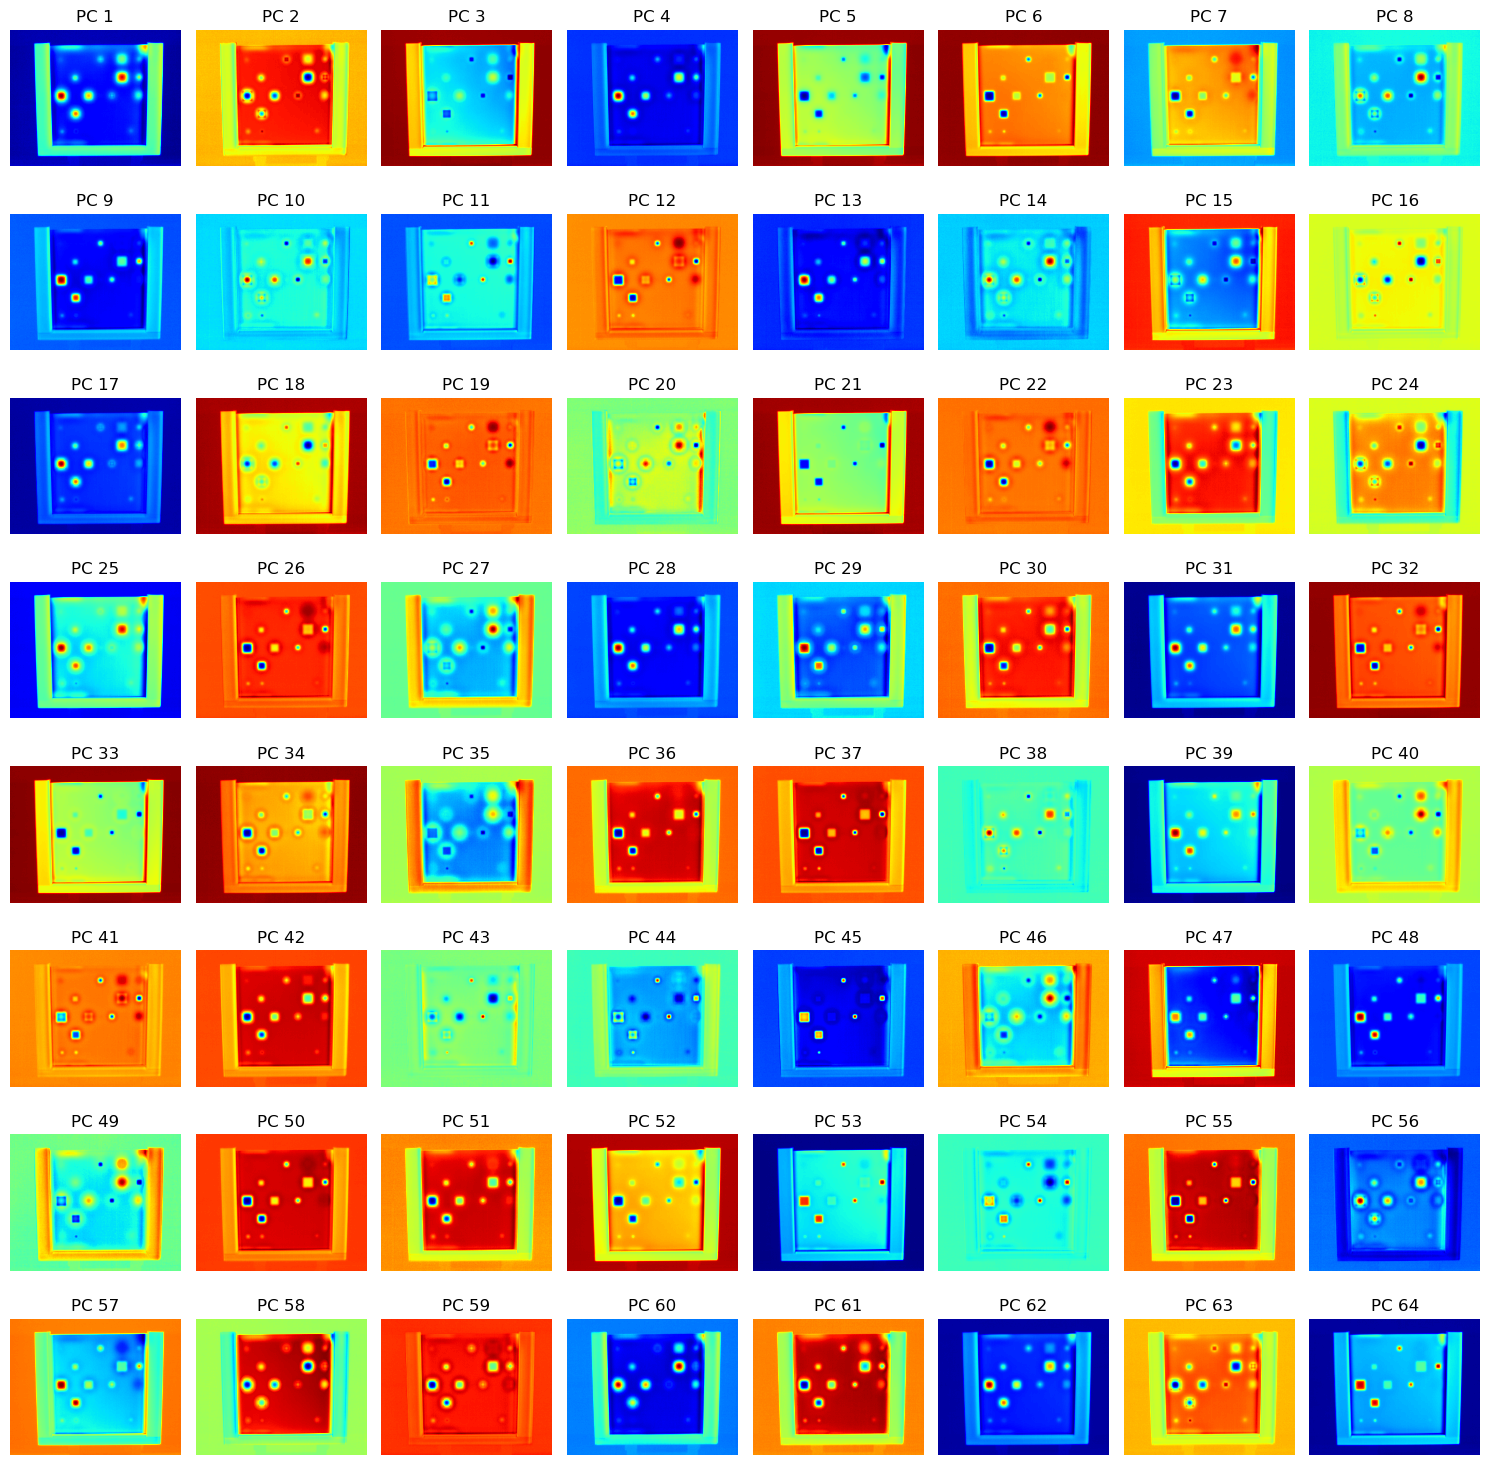

In [11]:
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_images[i], cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_images[i], cmap='jet')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()